C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


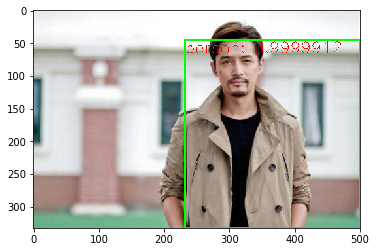

In [1]:
import cv2
import config
#import joblib
import alexnet
import operator 
import numpy as np
np.set_printoptions(suppress=True)
import tensorflow as tf
import matplotlib.pyplot as plt
from tool import image_rect_proposal, IOU, NMS

dropoutPro = 0.5
classNum = config.num_class +1
skip = []

imgMean = np.array([104, 117, 124], np.float)
x = tf.placeholder("float", [1, 227, 227, 3])

model = alexnet.AlexNet(x, dropoutPro, classNum, skip, weights_path= "./Models/AlexNet/alexnet_finetuned.npy")
sess = tf.Session() 
sess.run(tf.global_variables_initializer())
model.load_initial_weights(sess)
score = model.fc8
softmax = tf.nn.softmax(score)


            
def show_rect(img_path, regions):
    '''
    :param img_path: 要显示的原图片
    :param regions: 要在原图片上标注的矩形框的参数
    :param message: 在矩形框周围添加的信息
    :return: 
    '''
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for r in regions:
        x, y, x1, y1 =int(r['rect'][0]),int(r['rect'][1]),int(r['rect'][2]),int(r['rect'][3])
        rect = cv2.rectangle(
            img,(x, y), (x1, y1), (0,255,0),2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, "%s: %s"%(r['class'], r['prob']), (x, y+20),font, 0.8,(255,0,0),1)
    plt.imshow(img)
    plt.show()

def main():
    img_path = "./images/1.jpg"
    img =  cv2.imread(img_path)

    # 生成候选框
    pro_imgs, pro_rects = image_rect_proposal(img)
    # show_rect(img_path, pro_rects, '')
    
    # 提取每个候选框图像的特征
    # features = []
    

    car = []
    person = []
    bus = []

    count = 0
    for img in pro_imgs:
        r = {}
        img = img - imgMean
        # feature = sess.run(softmax, feed_dict = {x: img.reshape((1, 227, 227, 3))})
        probs = sess.run(softmax, feed_dict = {x: img.reshape((1, 227, 227, 3))})
        r['rect'] = pro_rects[count]
        r['prob'] = probs[0][1]
        if np.argmax(probs) == 0:
            r['class'] = config.class_name[0]
            bus.append(r)
        if np.argmax(probs) == 1:
            r['class'] = config.class_name[1]
            person.append(r)
        if np.argmax(probs) == 2:
            r['class'] = config.class_name[2]
            car.append(r)
        count +=1
    
    result_rects =[]
    result_rects.extend(NMS(bus, 0.1))
    result_rects.extend(NMS(person, 0.1))
    result_rects.extend(NMS(car, 0.1))
    

    show_rect(img_path, result_rects)
    # # 将特征输入到SVM分类器进行分类
    # svms = []
    # clf = joblib.load("./Models/SVM_models/bus.pkl")
    # svms.append(clf)
    # # print(clf)
    # count = 0
    # result_rects = []
    # for f in features:
    #     for svm in svms:
    #         pred = svm.predict([f.tolist()])
    #         print(pred)
    #         if pred[0] != config.background_index:
    #             result_rects.append(pro_rects[count])
    #     count +=1
    # show_rect(img_path, result_rects, '')



if __name__ == '__main__':
    main()